# Solving Models (with `jax`)

In [1]:
import jax
import jax.numpy as np
import jax.lax as lax
import matplotlib.pyplot as plt

In [2]:
# configure matplotlib output
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
col = mpl.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

In [3]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

In [4]:
# some warnings can get annoying
import warnings
warnings.filterwarnings('ignore')

## Optimization with JAX

Optimization typically involves looping in some way, so we need to be a bit careful when using `jax`. But you can achieve all of the same results with much more flexibility and speed at runtime. Here we're using simple gradient descent for opimization.

### Simple Function

In [5]:
# hardcoded step size
Δ = 0.1

In [6]:
# simple function
f = lambda x: -(x-1)**2 + 1
df = jax.grad(f)
vdf = jax.vmap(df)

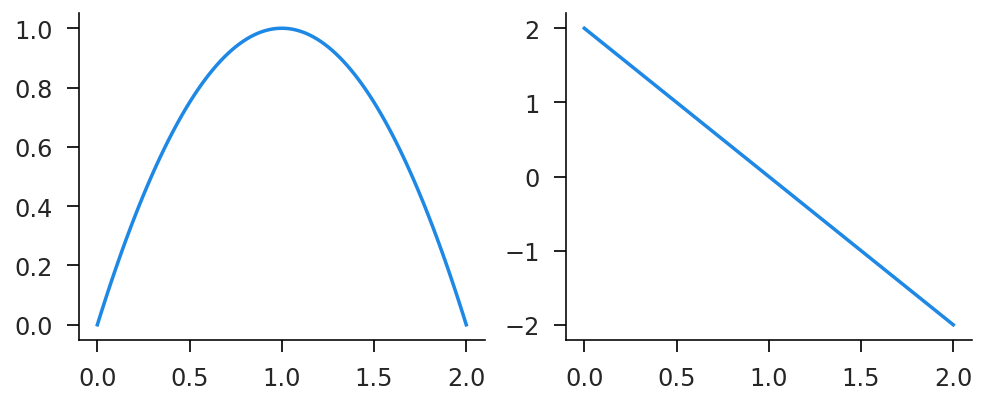

In [7]:
# visualize value and gradient
xgrid = np.linspace(0, 2, 100)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3))
ax0.plot(xgrid, f(xgrid))
ax1.plot(xgrid, vdf(xgrid));

In [8]:
# we define an update step function and one to apply it with scan
def update_scalar(x, t):
    xp = x + Δ*df(x)
    return xp, xp
def maximize_func(x0, K=50):
    tvec = np.arange(K) # this just has to be the right shape (K)
    x1, xvec = lax.scan(update_scalar, x0, tvec)
    return x1, xvec

In [9]:
# jit'ed scalar and vectorized versions
jmax_func = jax.jit(maximize_func)
vmax_func = jax.jit(jax.vmap(maximize_func))

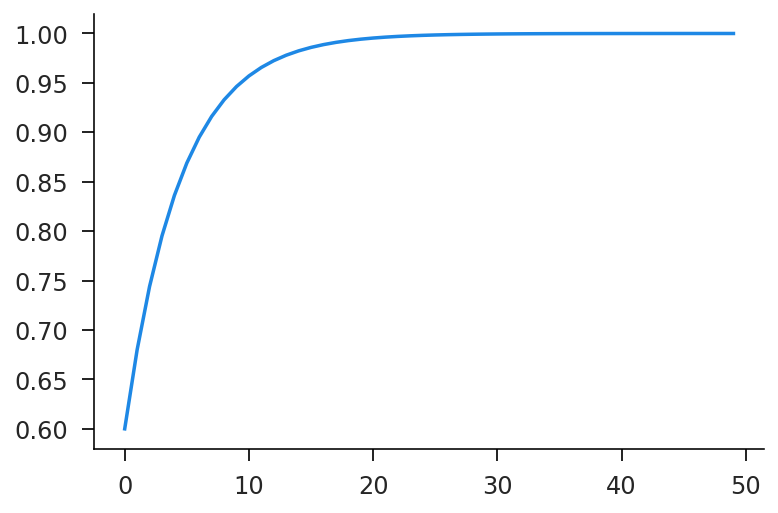

In [10]:
# run for just one starting value
x1, xvec = jmax_func(0.5)
plt.plot(xvec);

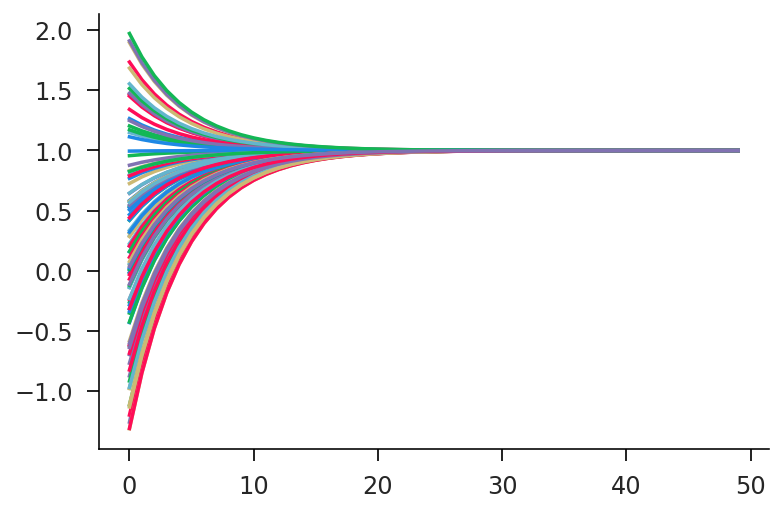

In [11]:
# run for many starting values simultaneously
key = jax.random.PRNGKey(42)
xrand = jax.random.normal(key, (100,))
x1, xvec = vmax_func(xrand)
plt.plot(xvec.T);

### Parameterized

Now let's add in an additional parameter $\alpha$ which influences the optimization

In [12]:
# parameterized function (max=α)
f1 = lambda x, α: -(x-α)**2
df1 = jax.grad(f1)
vdf1 = jax.vmap(df1)

In [13]:
# we just need to apply α to function before optimizing
def update_scalar(α, x, t):
    xp = x + Δ*df1(x, α)
    return xp, xp
def maximize_func(α, x0, K=50):
    tvec = np.arange(K)
    upd = lambda x, t: update_scalar(α, x, t)
    x1, xvec = lax.scan(upd, x0, tvec)
    return x1, xvec

In [14]:
jmax_func = jax.jit(maximize_func)
vmax_func = jax.jit(jax.vmap(maximize_func, in_axes=(0, None)))

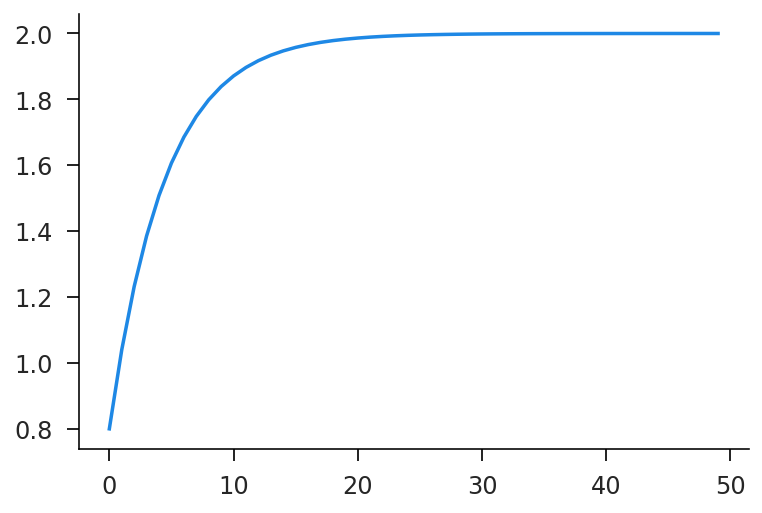

In [15]:
# run the scalar optimization for α = 2
x1, xvec = jmax_func(2.0, 0.5)
plt.plot(xvec);

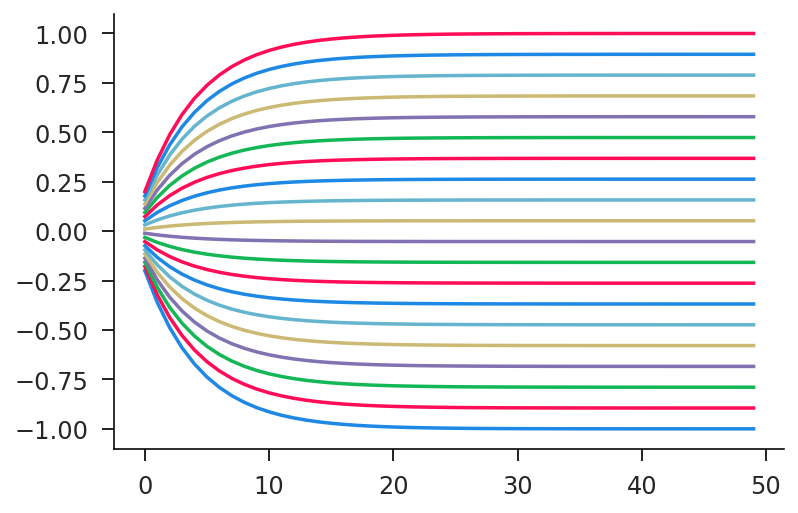

In [16]:
# run the optimization for a range of α's
αgrid = np.linspace(-1, 1, 20)
x1, xvec = vmax_func(αgrid, 0.0)
plt.plot(xvec.T);

We can even take the derivative of the optimal solution with respect to $\alpha$, which should always be $1$ in our case since $x^{\ast}(\alpha) = \alpha$.

In [17]:
dmax_func_out = jax.grad(lambda α, x0: maximize_func(α, x0)[0], argnums=0)
vmax_func_out = jax.vmap(dmax_func_out, in_axes=(0, None))
vmax_func_out(αgrid, 0.5)

DeviceArray([0.99998564, 0.99998564, 0.99998564, 0.99998564, 0.99998564,
             0.99998564, 0.99998564, 0.99998564, 0.99998564, 0.99998564,
             0.99998564, 0.99998564, 0.99998564, 0.99998564, 0.99998564,
             0.99998564, 0.99998564, 0.99998564, 0.99998564, 0.99998564],            dtype=float32)

## Value Functions With `jax`

Below is an implementation of simple value function iteration using `jax` for the neoclassical growth model. This makes use of trees for parameter values and the `scan` function for iteration. We start by defining parameters and the utility and production functions, as well as constructing the capital grid and finding the analytic steady state.

In [18]:
from functools import partial

In [19]:
# fixed params
T = 300 # time periods
N = 100 # grid size
f_lo, f_hi = 0.5, 2.0 # proportional grid range

In [20]:
# simple parameters
par0 = {
    'β': 0.95,
    'δ': 0.1,
    'α': 0.35,
    'z': 1.0,
}

In [21]:
# find steady state
def get_kss(par):
    β, δ, z, α = par['β'], par['δ'], par['z'], par['α']
    rhs = (1-β)/β + δ
    k = (α*z/rhs)**(1/(1-α))
    return k
k_ss = get_kss(par0)

In [22]:
# construct capital grid
k_min = f_lo*k_ss
k_max = f_hi*k_ss
k_grid = np.linspace(k_min, k_max, N)

In [23]:
# defined functions
def util(c, ϵ=1e-6):
    c1 = np.maximum(ϵ, c)
    return np.log(c1)
def prod(k, z, α):
    return z*k**α

Now we define the actual updating rule and the outer solving function.

In [24]:
# the value function update function
def value(par, grid, st, tv):
    β = par['β']
    cp = grid['cp']
    vn = st['vn']

    # calculate optimal investment
    vp = util(cp) + β*vn[None,:]
    ip = np.argmax(vp, axis=1)
    vp = np.max(vp, axis=-1)

    # apply at values
    kp = k_grid[ip]
    
    # compute update errors
    err = np.max(np.abs(vp-vn))

    # return state and output
    stp = {
        'vn': vp,
    }
    out = {
        'v': vp,
        'kp': kp,
        'err': err,
    }
    
    return stp, out

In [25]:
# the actual solver (T is the number of iterations)
def solve(par, T):
    α = par['α']
    δ = par['δ']
    z = par['z']

    # precompute grid values
    y_grid = prod(k_grid, z, α)
    yd_grid = y_grid + (1-δ)*k_grid
    cp_grid = yd_grid[:,None] - k_grid[None,:]

    # partially apply grid
    grid = {
        'cp': cp_grid,
    }
    value1 = partial(value, par, grid)

    # scan over time (backwards)
    st0 = {
        'vn': util(y_grid),
    }
    tv = {
        't': np.arange(T)[::-1],
    }
    last, path = lax.scan(value1, st0, tv)

    return path

Now let's time the model and see how the results look!

In [26]:
# jit and run once to ensure compilation
jsolve = jax.jit(solve, static_argnums=(1,))
ret = jsolve(par0, T)

In [27]:
# get some timing numbers
%timeit -r 10 -n 10 jsolve(par0, T)

3.64 ms ± 379 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


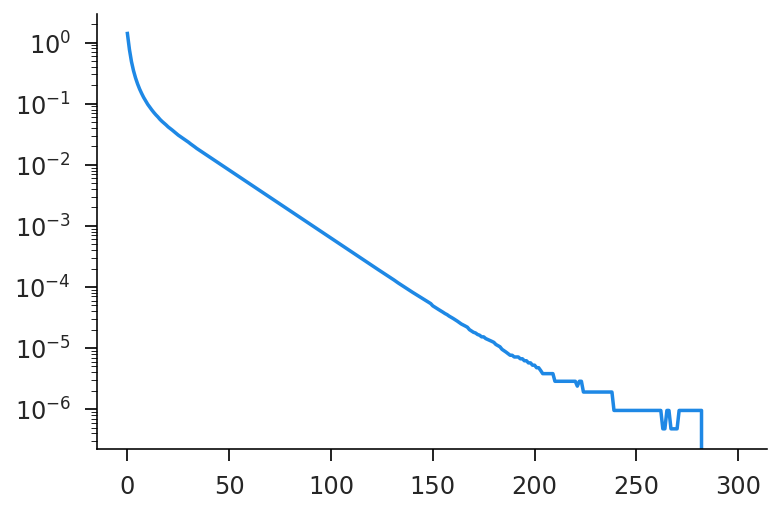

In [28]:
# plot the log error over the whole run
plt.plot(ret['err'])
plt.yscale('log');

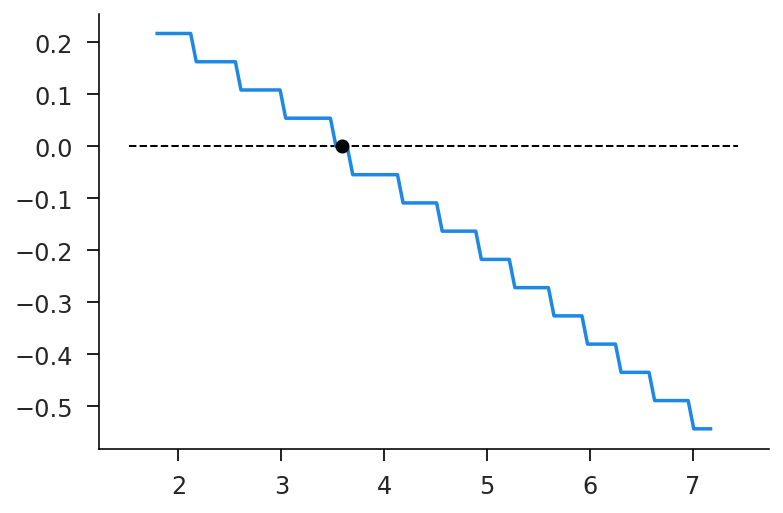

In [29]:
# make sure our policy function lines up with the analytic steady state
fig, ax = plt.subplots()
ax.plot(k_grid, ret['kp'][-1,:]-k_grid);
ax.hlines(0, *ax.get_xlim(), linestyle='--', linewidth=1, color='k')
ax.scatter(k_ss, 0, color='k', zorder=10);

## State Distributions

The flip side to solving value functions is constructing state distributions, either as they evolve or in steady state. Let's consider the system described in the lecture slides.

In [30]:
import jax.scipy.stats as stats

In [31]:
# algorithm params
N = 101
Δ = 0.1

In [32]:
# model params
λ = 1.1
τ = 0.1
κ = 0.02
μ = 0.0
σ = 0.3
g = np.log(λ)*τ

In [33]:
# construct grid
qmin, qmax = 0.0, 5.0
qbins = np.linspace(qmin, qmax, N)
qlow, qhigh = qbins[:-1], qbins[1:]
qmids = 0.5*(qlow+qhigh)
qdiff = qhigh - qlow

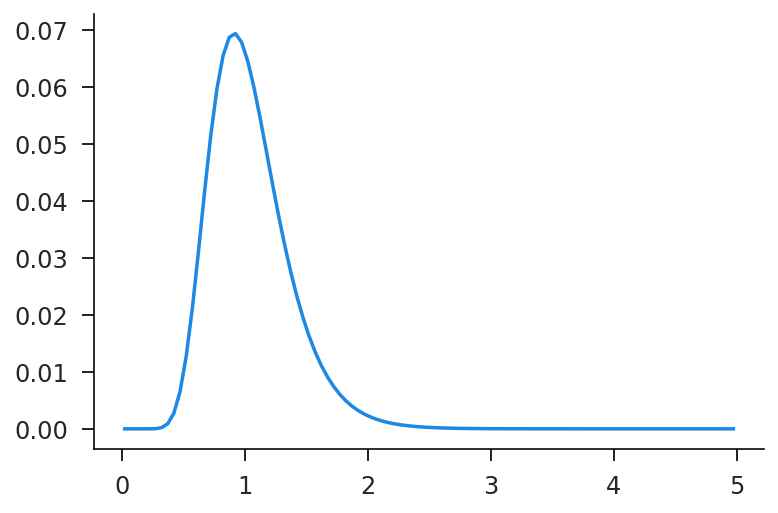

In [34]:
# entry distribution
ecdf = stats.norm.cdf(np.log(qbins), μ, σ)
ecdf /= ecdf[-1]
epmf = np.diff(ecdf)
plt.plot(qmids, epmf);

In [35]:
# range distributor
def split_range(q1, q2):
    return np.maximum(0, np.minimum(q2, qhigh) - np.maximum(q1, qlow))
v_split_range = jax.vmap(split_range)

In [36]:
gdel = 1 - Δ*g
λdel = λ*gdel
τdel = Δ*τ
κdel = Δ*κ
qdrop = v_split_range(gdel*qlow, gdel*qhigh)/(gdel*qdiff[:, None])
qjump = v_split_range(λdel*qlow, λdel*qhigh)/(λdel*qdiff[:, None])
qstay = τdel*qjump + (1-τdel)*qdrop
qtmat = κdel*epmf[None, :] + (1-κdel)*qstay

In [37]:
def iterate_mat(dist, tmat, T=4000):
    hist = [dist]
    for i in range(T):
        dist = dist @ tmat
        hist.append(dist)
    return np.vstack(hist)

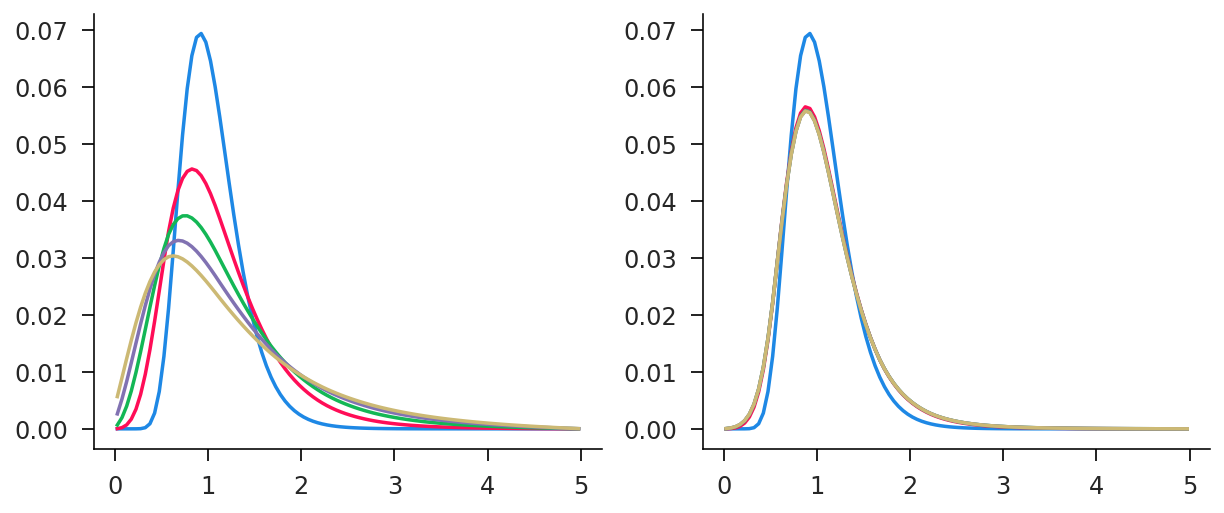

In [38]:
hist0 = iterate_mat(epmf, qstay)
hist1 = iterate_mat(epmf, qtmat)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 4))
ax0.plot(qmids, hist0[::1000, :].T);
ax1.plot(qmids, hist1[::1000, :].T);